# Progetto ML
### Predizione del livello di progressione della malattia a un anno di distanza, utilizzando 10 variabili misurate sui pazienti.

### 1. Importo le librerie necessarie 

In [3]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix

### 2. Importo i dati e guardo la struttura del dataset

In [5]:
df = datasets.load_diabetes()

In [6]:
print(df['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [7]:
df.keys()

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])

In [8]:
# Con questo passaggio inserisco all'interno di 'X' i valori delle features e in 'y' le labels
X = df['data']
feature_names = df['feature_names']
# Creo un DataFrame e assegno i nomi delle colonne
X = pd.DataFrame(X, columns=feature_names)

y = df['target']
# Creo un DataFrame e assegno i nomi delle colonne
y = pd.DataFrame(y, columns=['label'])

In [9]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


### 3. Missing data: controllo l'eventuale presenza di missing value e ne valuto la gestione

In [11]:
X.isnull().any()

age    False
sex    False
bmi    False
bp     False
s1     False
s2     False
s3     False
s4     False
s5     False
s6     False
dtype: bool

### 4. Scaling e centering dei valori  
   Quando le variabili hanno scale diverse (ad esempio, una variabile può andare da 0 a 1, un'altra da 1000 a 10000), alcune variabili possono dominare sulle altre, e ciò può distorcere i risultati di molti modelli di machine learning. Lo scaling adatta tutte le grandezze alla stessa scala.  
   Il centering (centratura) aiuta a evitare distorsioni nelle distanze tra i punti nei modelli che utilizzano la distanza, come k-NN e SVM, migliorando l'accuratezza delle previsioni. Inoltre, nei modelli di regressione o di ottimizzazione, il centering può accelerare e stabilizzare il processo di apprendimento, rendendo l'ottimizzazione più efficiente.  
     
   *In questo caso specifico è possibile saltare questo passaggio perchè, come riportato nella descrizione del dataset e come osservabile nel df X, le features sono già state sottoposte a questo pre-processamento.*

### 5. Suddivisione dei dati in training set e test set
Utilizzo la funzione train_test_split di scikit-learn per suddividere il dataset in due set distinti: uno per l'addestramento (train) e uno per il test.  
  
#### Parametri:
##### 1. X e y  
X rappresenta le feature (variabili indipendenti) del dataset, cioè le informazioni che il modello utilizzerà per fare previsioni.  
y rappresenta la variabile target (variabile dipendente), cioè le etichette che il modello deve prevedere.  
##### 2. test_size=0.25  
test_size=0.25 indica che il 25% dei dati sarà utilizzato per il test, mentre il restante 75% sarà utilizzato per l'addestramento.  
##### 3. random_state=42  
random_state=42 è un valore fisso per il generatore di numeri casuali. Garantisce che la divisione tra training e test sia riproducibile.    

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 42)

### 6. Scelta del modello  
Per il dataset Diabetes è un problema di regressione (dato che l'obiettivo è prevedere un valore continuo), quindi occorre utilizzare un modello che permetta di fare predizioni su variabili numeriche, e che abbia almeno un iperparametro da validare.  
**Possibili modelli:**  
1. **Regressione Lineare**
Il modello di regressione lineare è un punto di partenza naturale. Ha pochi iperparametri e fornisce una visione chiara della relazione tra le variabili.  
2. **Random Forest Regressor**  
Le Random Forests sono una scelta eccellente per problemi complessi e non lineari, come la regressione con molte caratteristiche.
Non richiede una grande preparazione dei dati, gestisce bene la non linearità e non è molto sensibile alla scalatura delle variabili.  
3. **Support Vector Regressor (SVR)**
Adatto a problemi complessi: Gli SVM, in particolare il Support Vector Regressor (SVR), possono modellare relazioni non lineari molto complesse e sono adatti quando la variabilità del dato è alta.
Può funzionare molto bene se ottimizzato correttamente, ma tende ad essere più lento da addestrare e necessita di un tuning accurato degli iperparametri.  
6. **K-Nearest Neighbors Regressor (KNN)**  
Semplice e intuitivo: Il K-Nearest Neighbors (KNN) può essere una buona scelta per modelli semplici. Si basa su un'idea molto semplice: predice il valore medio dei vicini più prossimi.
Funziona bene per dataset con una distribuzione abbastanza uniforme, ma potrebbe non funzionare bene su set di dati ad alta dimensione o con relazioni molto non lineari.

### 6-bis. Cross-validazione  

La scelta del modello migliore per un determinato compito, come la regressione sul dataset Diabetes, può essere fatta utilizzando la tecnica della Cross-Validation (CV). La cross-validation aiuta a valutare la performance dei modelli su dati non visti, riducendo così il rischio di overfitting e consentendo una valutazione più robusta e accurata delle prestazioni dei modelli.  
  
Con la cross-validation i dati vengono suddivisi in K sottoinsiemi (detti folds). Ogni modello viene addestrato su una parte dei dati (il training set) e testato su un'altra parte (il test set). Questo processo viene ripetuto più volte per ciascun fold, e alla fine si calcola una media delle performance del modello, in questo caso si valutiamo la MSE.

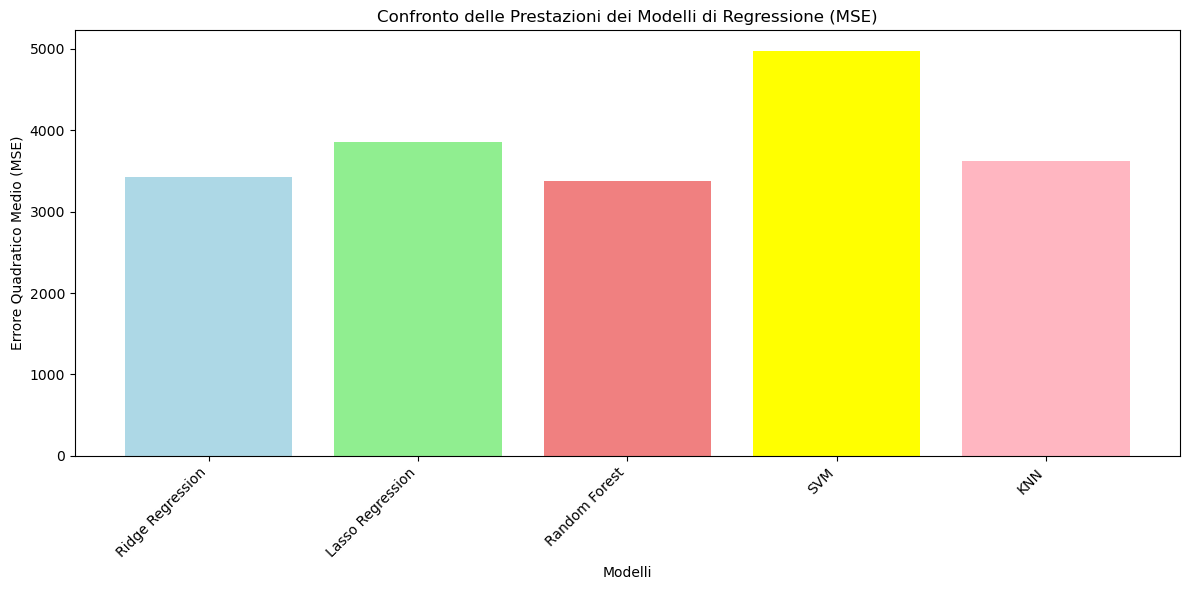

In [17]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

# Definisco i modelli da testare (Ridge e Lasso al posto di Linear Regression)
models = {
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "SVM": SVR(),
    "KNN": KNeighborsRegressor(n_neighbors=5)
}

# Lista per memorizzare i risultati
model_names = []
mean_mse_values = []

# Cross-validation (5-fold) per ciascun modello
for model_name, model in models.items():
    scores = cross_val_score(model, X, y.values.ravel(), cv=5, scoring='neg_mean_squared_error')
    mean_mse = -scores.mean()  
    model_names.append(model_name)
    mean_mse_values.append(mean_mse)

# Traccio il grafico dei risultati
plt.figure(figsize=(12, 6))
plt.bar(model_names, mean_mse_values, color=['lightblue', 'lightgreen', 'lightcoral', 'yellow', 'lightpink'])
plt.xlabel('Modelli')
plt.ylabel('Errore Quadratico Medio (MSE)')
plt.title('Confronto delle Prestazioni dei Modelli di Regressione (MSE)')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

L'uso di **Random Forest** in regressione offre numerosi vantaggi. In primo luogo, questo modello è in grado di gestire efficacemente **relazioni non lineari** tra le variabili indipendenti e il target, superando le limitazioni dei modelli lineari. Inoltre, essendo un metodo **ensemble**, Random Forest combina più alberi decisionali, riducendo il rischio di **overfitting**, soprattutto quando gli alberi sono molto profondi. Ogni albero è addestrato su un campione casuale dei dati e le previsioni finali sono la media delle previsioni degli alberi, il che contribuisce a migliorare la robustezza del modello. Infine, Random Forest tende a fornire buone prestazioni anche senza una **ottimizzazione complessa degli iperparametri**, funzionando bene anche con i valori predefiniti, il che lo rende una scelta affidabile e semplice da implementare in molti problemi di regressione.

### 7. Validazione dei parametri

In [20]:
# Creo il modello Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Definisco i parametri da validare
param_grid = {
    'n_estimators': [50, 100, 200, 300],         # Numero di alberi nella foresta
    'max_depth': [None, 1, 2, 3, 4, 5, 10, 20],              # Profondità massima degli alberi
}

# Eseguo Grid Search per la validazione degli iperparametri
# Per la regressione (in particolare con Random Forest Regressor), il metodo di scoring che viene solitamente utilizzato è l'errore quadratico medio negativo (neg_mean_squared_error). 
# Questo perché, quando si lavora con un modello di regressione, l'obiettivo è minimizzare l'errore tra le predizioni del modello e i valori reali.
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', verbose = 0) 
grid_search.fit(X_train, y_train.values.ravel())

# Visualizzo i migliori iperparametri
print(f"Migliori parametri: {grid_search.best_params_}")

Migliori parametri: {'max_depth': 5, 'n_estimators': 300}


### 8. Costruzione del modello e valutazione della sua performance  
Per la regressione (in particolare con Random Forest Regressor), il metodo di scoring che viene solitamente utilizzato è l'errore quadratico medio negativo (neg_mean_squared_error). 
Questo perché, quando si lavora con un modello di regressione, l'obiettivo è minimizzare l'errore tra le predizioni del modello e i valori reali.


In [22]:
from sklearn.metrics import mean_absolute_error

rf = RandomForestRegressor(random_state=42, max_depth = 5, n_estimators = 300)
rf.fit(X_train, y_train.values.ravel())

y_pred = rf.predict(X_test)  # Previsioni
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 42.19103347224715


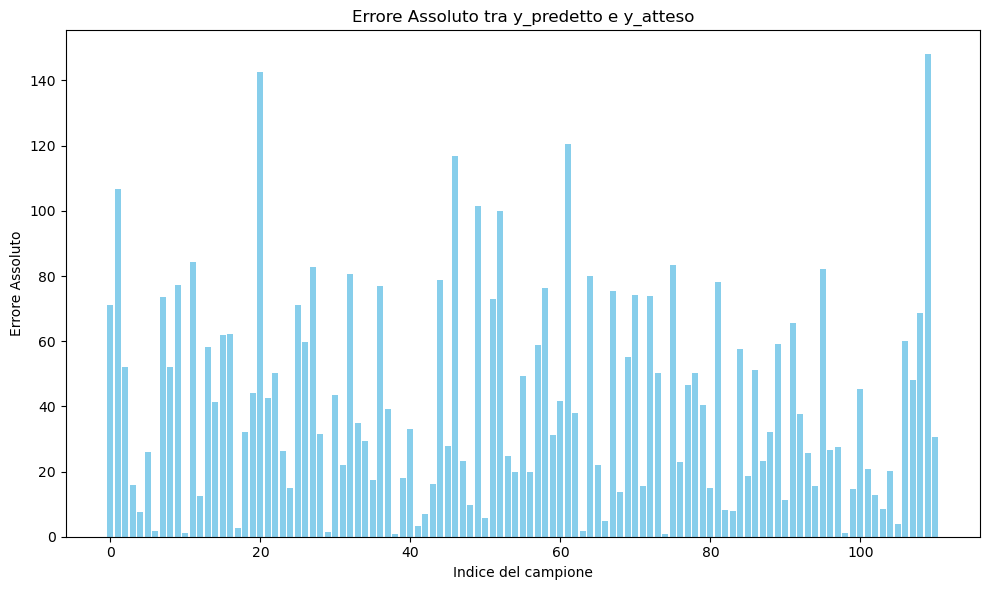

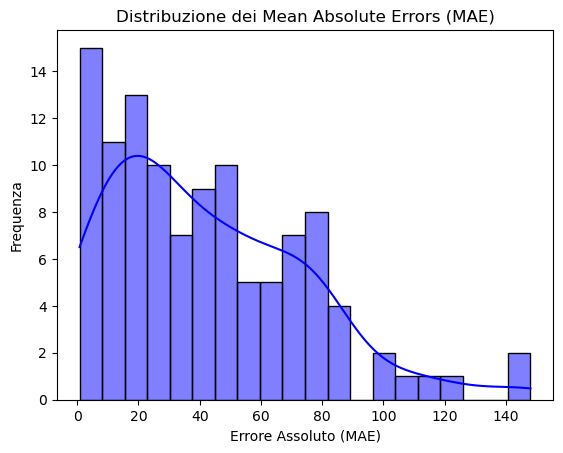

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error

# Calcolo l'errore assoluto per ogni previsione
errors = abs(y_pred - y_test.values.ravel())

# Grafico dell'errore assoluto
plt.figure(figsize=(10, 6))
plt.bar(range(len(errors)), errors, color='skyblue')
plt.xlabel('Indice del campione')
plt.ylabel('Errore Assoluto')
plt.title('Errore Assoluto tra y_predetto e y_atteso')
plt.tight_layout()
plt.show()

# Istogramma della distribuzione degli errori assoluti
sns.histplot(errors, kde=True, color='blue', bins=20)

plt.title("Distribuzione dei Mean Absolute Errors (MAE)")
plt.xlabel("Errore Assoluto (MAE)")
plt.ylabel("Frequenza")
plt.show()